In [1]:
import healpy as hp
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u

# White noise NET in Radio-astronomy and Cosmology
> Create a white noise map and compare with power spectrum expected from the NET
- categories: [cosmology, python, healpy]

Noise-Equivalent-Temperature, it is a measure of sensitivity of a detector, in cosmology, it is often quoted
in $\mu K \sqrt(s)$, i.e. it is the sensitivity per unit time and can be divided by the integration time to
get the actual standard deviation of the white noise of the instrument.

For example let's consider a white noise NET of $200 \mu K \sqrt(s)$

it means that if you integrate for 100 seconds for each pixel, the standard deviation will be $20 \mu K$.

In [2]:
net = 200 * u.Unit("uK * sqrt(s)")

In [3]:
net

<Quantity 200. s(1/2) uK>

In [4]:
integration_time_per_pixel = 100 * u.s

In [5]:
standard_deviation = net / np.sqrt(integration_time_per_pixel)

## Create a white noise map

Now that we have an estimate of the standard deviation per pixel, we can use `numpy` to create a map of gaussian white noise.

In [6]:
nside = 128
npix = hp.nside2npix(nside)

In [7]:
m = np.random.normal(scale = standard_deviation.value, size=npix) * standard_deviation.unit

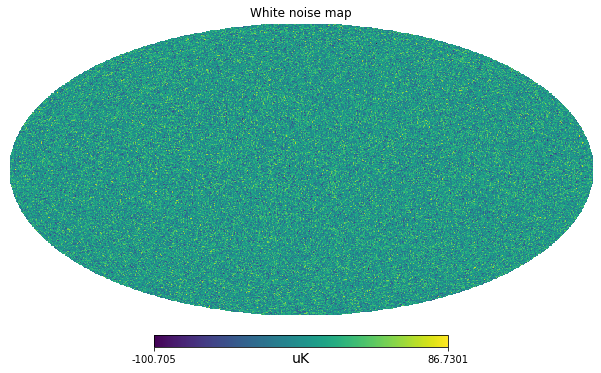

In [8]:
hp.mollview(m, unit=m.unit, title="White noise map")

## Power spectrum

Finally we can compute the angular power spectrum with `anafast`, i.e. the power as a function of the angular scales, from low $\ell$ values for large angular scales, to high $\ell$ values for small angular scales.

At low $\ell$ there is not much statistics and the power spectrum is biased, but if we exclude lower ells, we can have an estimate of the white noise $C_\ell$ coefficients. We can then compare with the theoretical power computed as:

$$ C_\ell = \Omega_{pix}\sigma^2 $$

Where: $\Omega_{pix}$ is the pixel are in square-radians and $\sigma^2$ is the white noise standard variance.

In [9]:
cl = hp.anafast(m)

In [10]:
cl[100:].mean()

0.02516797566530168

In [11]:
pixel_area = hp.nside2pixarea(nside)

In [12]:
white_noise_cl = standard_deviation.value**2 * pixel_area

In [13]:
white_noise_cl

0.025566346464760685

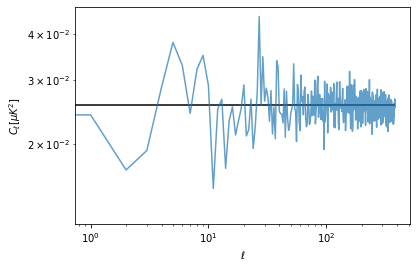

In [14]:
plt.figure(figsize=(6,4))
plt.loglog(cl, label="Map power spectrum", alpha=.7)
plt.hlines(white_noise_cl, 0, len(cl), label="White noise level")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K ^ 2]$");

## Masking

In case we are removing some pixels from a map, for example to mask out a strong signal (e.g. the Milky Way), our estimate of the power spectrum on the partial sky is lower.
However we assume that the properties of the noise will be the same also in the masked region.
At first order, for simple masks, we can just correct for the amplitude by dividing the power spectrum by the sky fraction.

In [15]:
m.value[len(m)//2-30000:len(m)//2+30000] = hp.UNSEEN

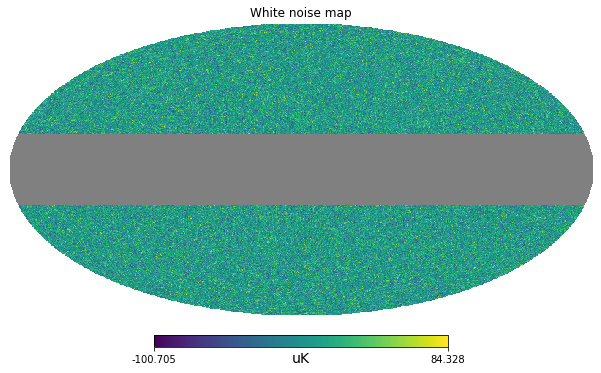

In [16]:
hp.mollview(m, unit=m.unit, title="White noise map")

In [17]:
cl_masked = hp.anafast(m)

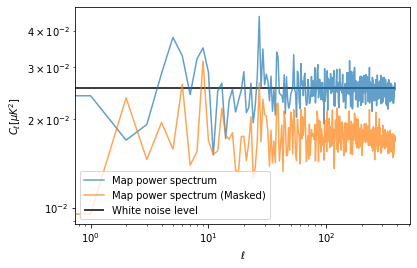

In [18]:
plt.figure(figsize=(6,4))
plt.loglog(cl, label="Map power spectrum", alpha=.7)
plt.loglog(cl_masked, label="Map power spectrum (Masked)", alpha=.7)
plt.hlines(white_noise_cl, 0, len(cl), label="White noise level")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K ^ 2]$")
plt.legend();

In [19]:
sky_fraction = hp.mask_good(m).sum() / len(m)
print(sky_fraction)

0.69482421875


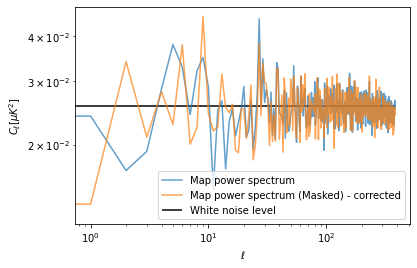

In [20]:
plt.figure(figsize=(6,4))
plt.loglog(cl, label="Map power spectrum", alpha=.7)
plt.loglog(cl_masked / sky_fraction, label="Map power spectrum (Masked) - corrected", alpha=.7)
plt.hlines(white_noise_cl, 0, len(cl), label="White noise level")
plt.xlabel("$\ell$")
plt.ylabel("$C_\ell [\mu K ^ 2]$")
plt.legend();